<a href="https://colab.research.google.com/github/Jmwspace1/quantum/blob/main/kak_theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.3 MB/s eta 0:00:00


In [6]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.9 MB/s eta 0:00:00


In [7]:
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
import pennylane as qml
from pennylane import X, Y, Z

import jax
import jax.numpy as jnp
import optax
jax.config.update("jax_enable_x64", True)

n_wires = 4
gens = [X(i) @ X(i+1) for i in range(n_wires-1)]
gens += [Y(i) @ Y(i+1) for i in range(n_wires-1)]
gens += [Z(i) @ Z(i+1) for i in range(n_wires-1)]

H = qml.sum(*gens)

g = qml.lie_closure(gens)
g = [op.pauli_rep for op in g]

In [8]:
def even_odd_involution(op):
    [pw] = op.pauli_rep
    return len(pw) % 2

even_odd_involution(X(0)), even_odd_involution(X(0) @ Y(3))

(1, 0)

In [9]:
def cartan_decomposition(g, involution):
    """Cartan Decomposition g = k + m

    Args:
        g (List[PauliSentence]): the (dynamical) Lie algebra to decompose
        involution (callable): Involution function :math:`\Theta(\cdot)` to act on PauliSentence ops, should return ``0/1`` or ``True/False``.

    Returns:
        k (List[PauliSentence]): the vertical subspace :math:`\Theta(x) = x`
        m (List[PauliSentence]): the horizontal subspace :math:`\Theta(x) = -x` """
    m = []
    k = []

    for op in g:
        if involution(op): # vertical space when involution returns True
            k.append(op)
        else: # horizontal space when involution returns False
            m.append(op)
    return k, m

k, m = cartan_decomposition(g, even_odd_involution)
len(g), len(k), len(m)

(60, 24, 36)

In [10]:
for op in H.operands:
    assert not even_odd_involution(op)

In [11]:
def _commutes_with_all(candidate, ops):
    r"""Check if ``candidate`` commutes with all ``ops``"""
    for op in ops:
        com = candidate.commutator(op)
        com.simplify()

        if not len(com) == 0:
            return False
    return True

def cartan_subalgebra(m, which=0):
    """Compute the Cartan subalgebra from the horizontal subspace :math:`\mathfrak{m}`
    of the Cartan decomposition

    This implementation is specific for cases of bases of m with pure Pauli words as
    detailed in Appendix C in `2104.00728 <https://arxiv.org/abs/2104.00728>`__.

    Args:
        m (List[PauliSentence]): the horizontal subspace :math:`\Theta(x) = -x
        which (int): Choice for the initial element of m from which to construct
            the maximal Abelian subalgebra

    Returns:
        mtilde (List): remaining elements of :math:`\mathfrak{m}`
            s.t. :math:`\mathfrak{m} = \tilde{\mathfrak{m}} \oplus \mathfrak{h}`.
        h (List): Cartan subalgebra :math:`\mathfrak{h}`.

    """

    h = [m[which]] # first candidate
    mtilde = m.copy()

    for m_i in m:
        if _commutes_with_all(m_i, h):
            if m_i not in h:
                h.append(m_i)

    for h_i in h:
        mtilde.remove(h_i)

    return mtilde, h

mtilde, h = cartan_subalgebra(m)
len(g), len(k), len(mtilde), len(h)

(60, 24, 24, 12)

In [12]:
gammas = [np.pi**i % 2 for i in range(1, len(h)+1)]

v = qml.dot(gammas, h)
v_m = qml.matrix(v, wire_order=range(n_wires))
v_m = jnp.array(v_m)

In [13]:
def run_opt(
    value_and_grad,
    theta,
    n_epochs=500,
    lr=0.1,
):
    """Boilerplate JAX optimization"""
    value_and_grad = jax.jit(jax.value_and_grad(loss))
    optimizer = optax.lbfgs(learning_rate=lr, memory_size=100)
    opt_state = optimizer.init(theta)

    energy = []
    gradients = []
    thetas = []

    @jax.jit
    def step(opt_state, theta):
        val, grad_circuit = value_and_grad(theta)
        updates, opt_state = optimizer.update(
            grad_circuit, opt_state, theta, value=val, grad=grad_circuit, value_fn=loss
        )
        theta = optax.apply_updates(theta, updates)

        return opt_state, theta, val

    t0 = datetime.now()
    ## Optimization loop
    for _ in range(n_epochs):
        opt_state, theta, val = step(opt_state, theta)

        energy.append(val)
        thetas.append(theta)

    t1 = datetime.now()
    print(f"final loss: {val}; min loss: {np.min(energy)}; after {t1 - t0}")

    return thetas, energy, gradients

final loss: -147.6628502125487; min loss: -147.66285021254893; after 0:02:18.261833


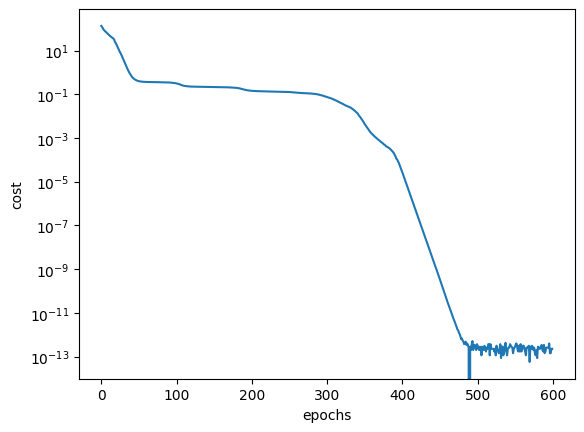

In [14]:
H_m = qml.matrix(H, wire_order=range(n_wires))
H_m = jnp.array(H_m)

def K(theta, k):
    for th, k_j in zip(theta, k):
        qml.exp(-1j * th * k_j.operation())

@jax.jit
def loss(theta):
    K_m = qml.matrix(K, wire_order=range(n_wires))(theta, k)
    A = K_m @ v_m @ K_m.conj().T
    return jnp.trace(A.conj().T @ H_m).real

theta0 = jnp.ones(len(k), dtype=float)

thetas, energy, _ = run_opt(loss, theta0, n_epochs=600, lr=0.05)
plt.plot(energy - np.min(energy))
plt.xlabel("epochs")
plt.ylabel("cost")
plt.yscale("log")
plt.show()